# Fake News Classification with CNN and CNN-LSTM 

In [1]:
#Normal Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
from tensorflow import keras as k

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, Activation, BatchNormalization, LSTM, TimeDistributed
from keras.layers import Concatenate, Conv2D, MaxPooling2D, GRU
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding

import tensorflow as tf
from textblob import TextBlob
from collections import Counter
from keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import regex as re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics


def read_pairs(path, separator='\t', cast=(str, str), offset=0):
    with open(path) as f:
        return [(cast[0](k), cast[1](v)) for line in f.readlines()[offset:] for k, v in [line.rstrip().split(separator)]]


### Importing the dataset

In [25]:
test_path = "../../data/final/test.csv"

raw_data_test = dict(read_pairs(test_path, cast=(int,str), offset=1))
data_test = {
    'id': pd.Index(list(raw_data_test.keys())),
    'text': pd.Index(list(raw_data_test.values()))
}

test = pd.DataFrame(data_test)

# train_path = "../../data/final/train.csv"

# raw_data_train = dict(read_pairs(train_path, cast=(str,int), offset=1))
# data_train = {
#     'text': pd.Index(list(raw_data_train.keys())),
#     'label': pd.Index(list(raw_data_train.values()))
# }

# train = pd.DataFrame(data_train)

In [60]:
train = pd.read_csv("../../data/final/data_cleaned.csv")

In [61]:
train.head()

,text,label,len_content,avg_len,sent,lexical_diver,use_super,len_exclaim,len_question,first_person
0,get the latest from today sign up for our news...,1,1637,308.0,-0.5719,0.571429,1,0,0,8
1,conan on the funeral trump will be invited to ...,1,58,12.0,-0.3612,0.833333,0,0,0,0
2,it safe to say that instagram stories has far ...,0,2563,443.0,0.9863,0.575621,1,0,0,5
3,much like a certain amazon goddess with a lass...,0,9689,1799.0,0.9994,0.373541,5,0,0,32
4,at a time when the perfect outfit is just one ...,0,869,144.0,0.7234,0.736111,0,0,0,0


In [57]:
test.head()

,id,text,len_content,avg_len,sent,lexical_diver,use_super,len_exclaim,len_question,first_person
0,2,the teen choice awards ceremony was held on au...,1028,166.0,0.9657,0.638554,1,0,0,0
1,3,the concert part of joshua tree tour was slate...,3009,534.0,-0.9842,0.522472,0,0,0,11
2,4,selena gomez refuses to talk to her mother abo...,1652,296.0,0.9934,0.483108,0,0,0,2
3,5,this is worse than a lump of coal in your stoc...,2123,396.0,0.9895,0.487374,0,0,0,1
4,6,luann de lesseps is going to rehab after her a...,1330,232.0,0.9588,0.642241,1,0,0,5


### Preprocessing for test dataset

## Creation of Handpicked Features


During our consultation, we felt that there may be additional features that we may find interesting and we would want to feed into our model. These include:

* Total number of words in the text
* The average length of words in a sentence in the text
* The number of exclamations
* The number of question marks
* The number of superlatives in the text
* Sentiment Analysis of the text
* Usage of first person pronouns
* Lexical Diversity

In [27]:
## Auxillary functions

def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumeric characters
    words = [word.lower() for word in tokens if word.isalpha()]    
    return ' '.join(words)


def clean_text_array(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumeric characters
    words = [word.lower() for word in tokens if word.isalpha()]  
    return words

#This function calculates the average length of text and puts them in a vector per row in the dataframe
def average_length(text):
    average_length_list = []
    for txt in text:
        sentences = sent_tokenize(txt) #splitting into sentences
        num_words = [len(sentence.split(' ')) for sentence in sentences] #numwords per sentence
        average = sum(num for num in num_words)/(len(sentences)) #average number of words / sentence for 
        average_length_list.append(average) #len words per text 
    return average_length_list


#Counts the words that are in first person
def count_person_forms(text, person):
    text = tokenize(text.lower())
    counter = 0
    for word in text:
        if word in person:
            counter += 1
    return counter

#Sentiment analysis using vader sentiment
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

def classify_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    text = text.replace("\n\n", ". ").replace("\n", ". ")
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    pol = sid.polarity_scores(text)['compound']
    return pol

#Count the lexical diversity of the text
def lexical_diversity(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = tokenize(text.lower())
    if len(text) == 0:
        return 0
    return len(set(text)) / len(text)

def percentage(count, total):
    return 100 * count / total

#Counts the number of superlatives in the text
from textblob import TextBlob

def textblob_adj(text):
    blobed = TextBlob(text)
    counts = Counter(tag for word,tag in blobed.tags)
    super_list = []
    super_tag_list = ['JJS','RBS']
    for (a, b) in blobed.tags:
        if b in super_tag_list:
           super_list.append(a)
    return counts['JJS'] + counts['RBS']

def list_superlatives(text):
    add_list = []
    for txt in text:
        add_list.append(textblob_adj(txt))
    return add_list

from nltk.tokenize import RegexpTokenizer
def tokenize(text):
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    return tokens

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chengling/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [47]:
train['text'] = train.apply(lambda row: clean_text(row['text']), axis=1)
train['len_content'] = train.apply(lambda row: len(row['text']), axis=1)
test['text'] = test.apply(lambda row: clean_text(row['text']), axis=1)
test['len_content'] = test.apply(lambda row: len(row['text']), axis=1)

In [51]:
test['avg_len'] = average_length(test['text'])

test['sent'] = test.apply(lambda r: classify_sentiment(r['text']), axis=1)

test['lexical_diver'] = test.apply(lambda r: lexical_diversity(r['text']), axis=1)

test = test.assign(use_super = list_superlatives(test.text))

test['len_exclaim'] = test.text.str.count("!")
test['len_question']= test.text.str.count("\?")

first_person = ["i", "me", "mine", "we", "us", "our", "ours"]
test['first_person'] = test.apply(lambda row: count_person_forms(row['text'], first_person), axis=1)


In [53]:
test.head()

,text,label,len_content,avg_len,sent,lexical_diver,use_super,len_exclaim,len_question,first_person
0,get the latest from today sign up for our news...,1,1637,308.0,-0.5719,0.571429,1,0,0,8
1,conan on the funeral trump will be invited to ...,1,58,12.0,-0.3612,0.833333,0,0,0,0
2,it safe to say that instagram stories has far ...,0,2563,443.0,0.9863,0.575621,1,0,0,5
3,much like a certain amazon goddess with a lass...,0,9689,1799.0,0.9994,0.373541,5,0,0,32
4,at a time when the perfect outfit is just one ...,0,869,144.0,0.7234,0.736111,0,0,0,0


## Padding and embedding the data

We use the GloVe embeddings...

In [62]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.text)

#tokenizing by word, maybe can think of way to tokenize by sentence
word_index = tokenizer.word_index
vocab_size = len(word_index)

print(vocab_size)

56608


In [88]:
#padding data 

sequences = tokenizer.texts_to_sequences(train.text)
padded = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')


In [92]:
embeddings_index = {}
with open('../experimental/rnn/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector


100


In [97]:
explicit_train = train.iloc[0:,2:]

In [98]:
x_train,x_test,new_train,new_test,y_train,y_test = train_test_split(padded,explicit_train,train.label,test_size = 0.2,random_state = 42)

print('Shape of training data: ') #number of dimension in the array
print(x_train.shape) 
print(y_train.shape)
print('Shape of test data: ') #number of dimension in the array
print(x_test.shape)
print(y_test.shape)
print('Shape of textual explicit data: ') #number of dimension in the array
print(new_train.shape)
print(new_test.shape)

Shape of training data: 
(3784, 500)
(3784,)
Shape of test data: 
(947, 500)
(947,)
Shape of textual explicit data: 
(3784, 8)
(947, 8)


### Tokenizing and embedding of test data

In [94]:
tokenizer_test = Tokenizer()
tokenizer_test.fit_on_texts(test.text)

#tokenizing by word, maybe can think of way to tokenize by sentence
word_index_test = tokenizer_test.word_index
vocab_size_test = len(word_index_test)

print(vocab_size_test)

30395


In [95]:
#padding data 

sequences_test = tokenizer_test.texts_to_sequences(test.text)
padded_test = pad_sequences(sequences_test, maxlen=500, padding='post', truncating='post')

In [96]:
embeddings_index_test = {}
with open('../experimental/rnn/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index_test[word] = coefs
print(len(coefs))

embeddings_matrix_test = np.zeros((vocab_size_test+1, 100))
for word, i in word_index_test.items():
    embedding_vector = embeddings_index_test.get(word)
    if embedding_vector is not None:
        embeddings_matrix_test[i] = embedding_vector

100


In [99]:
explicit_test = test.iloc[0:,2:]

## CNN Model

In this first test, we will create our CNN model without our additional features 

In [200]:
model = Sequential()
model.add(Embedding(vocab_size+1, 100, input_length=500))

model.add(Conv1D(filters=80, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(150,activation = "relu"))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 100)          5660900   
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 498, 80)           24080     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 249, 80)           0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 249, 80)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 19920)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 150)               2988150   
_________________________________________________________________
dropout_25 (Dropout)         (None, 150)              

In [201]:
model.compile(k.optimizers.Adam(lr=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(k.optimizers.SGD(lr=0.1, momentum = 0.1), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(k.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 100)          5660900   
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 498, 80)           24080     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 249, 80)           0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 249, 80)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 19920)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 150)               2988150   
_________________________________________________________________
dropout_25 (Dropout)         (None, 150)              

In [202]:
history = model.fit(x_train, y_train, epochs=20, batch_size=100, validation_data=(x_test, y_test),callbacks = [k.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, min_delta = 0.01)])

Epoch 1/20
38/38 [==============================] - 12s 321ms/step - loss: 0.6766 - accuracy: 0.5933 - val_loss: 0.6711 - val_accuracy: 0.6072
Epoch 2/20
38/38 [==============================] - 10s 262ms/step - loss: 0.6416 - accuracy: 0.6229 - val_loss: 0.6504 - val_accuracy: 0.6061
Epoch 3/20
38/38 [==============================] - 11s 280ms/step - loss: 0.5033 - accuracy: 0.7748 - val_loss: 0.5653 - val_accuracy: 0.7086
Epoch 4/20
38/38 [==============================] - 11s 277ms/step - loss: 0.2505 - accuracy: 0.9107 - val_loss: 0.4949 - val_accuracy: 0.7709
Epoch 5/20
38/38 [==============================] - 11s 284ms/step - loss: 0.0990 - accuracy: 0.9775 - val_loss: 0.5447 - val_accuracy: 0.7624
Epoch 6/20
38/38 [==============================] - 10s 275ms/step - loss: 0.0444 - accuracy: 0.9915 - val_loss: 0.6048 - val_accuracy: 0.7730


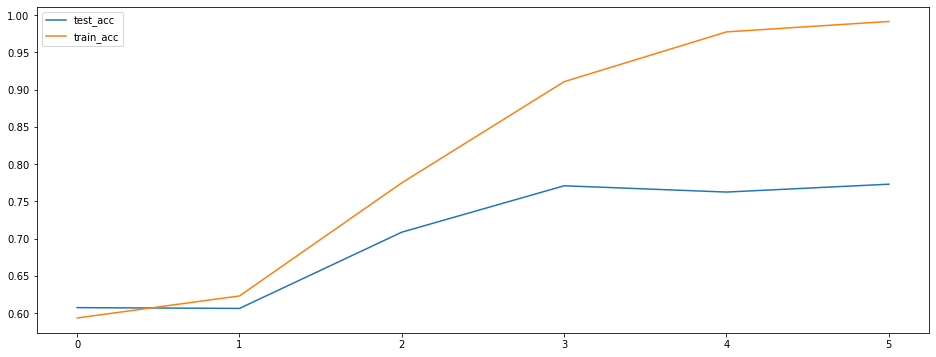

In [203]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_accuracy'], label='test_acc')
plt.plot(history.history['accuracy'], label='train_acc')
plt.legend()

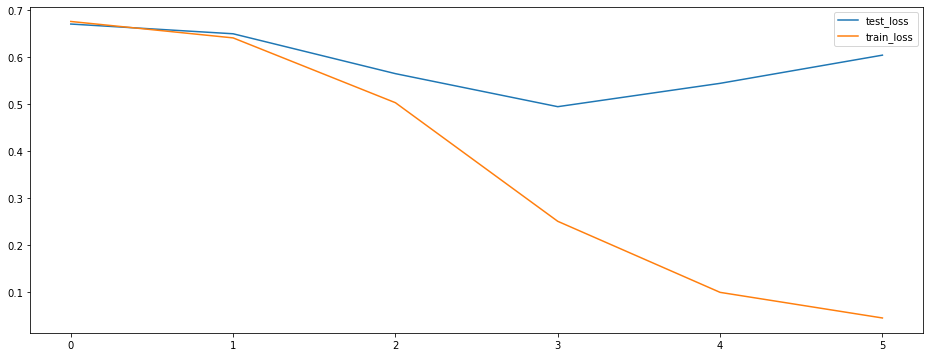

In [204]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_loss'], label='test_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.legend()

In [205]:
test_pred = model.predict(x_test)
accuracy_score(y_test, test_pred.round())

0.7729672650475184

In [206]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       575
           1       0.74      0.65      0.69       372

    accuracy                           0.77       947
   macro avg       0.77      0.75      0.76       947
weighted avg       0.77      0.77      0.77       947



[[477  98]
 [121 251]]


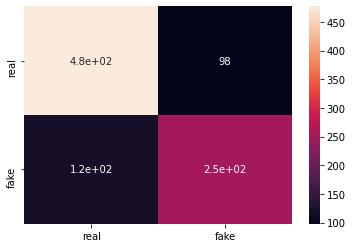

In [199]:
matrix = confusion_matrix(y_test, test_pred.round())
print(matrix)

#Plot
df_cm = pd.DataFrame(matrix, columns=['real','fake'], index=['real', 'fake'])
sns.heatmap(df_cm, annot=True)

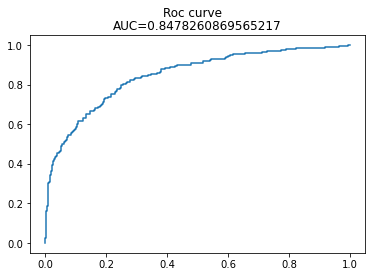

In [108]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
auc = metrics.roc_auc_score(y_test, test_pred)

fig,ax = plt.subplots()
ax.set_title('AUC={}'.format(auc))
fig.suptitle('Roc curve')
ax.plot(fpr,tpr)

In [216]:
test_pred1 = model.predict(padded_test)
test1 = test.copy()
test1["label"] = test_pred1
for i in range(len(test1)):
    if test1.label[i] <0.5:
        test1.label[i] = 0 
    else:
        test1.label[i] = 1

## CNN Model with additional text explicit features

In [137]:
## two shapes of inputs
input_1 = Input(shape=(500,))
input_2 = Input(shape=(8,))

##Text layer
embedding_layer = Embedding(vocab_size+1, 100, weights=[embeddings_matrix])(input_1)
conv1_layer1 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding_layer)
pool_layer1 = MaxPooling1D(pool_size=4)(conv1_layer1)

conv1_layer2 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool_layer1)
pool_layer2 = MaxPooling1D(pool_size=4)(conv1_layer2)

conv1_layer3 = Conv1D(filters=128, kernel_size=3, activation='relu')(pool_layer2)
pool_layer3 = MaxPooling1D(pool_size=4)(conv1_layer3)

flat_layer = Flatten()(pool_layer3)

## Textual Explicit Features Layer
dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

#Combining layers
concat_layer = Concatenate()([flat_layer, dense_layer_2])
dense_layer_3 = Dense(128, activation='relu')(concat_layer)

dense_layer_4 = Dense(10, activation='relu')(dense_layer_3)

output = Dense(1, activation='sigmoid')(dense_layer_4)
model = Model(inputs=[input_1, input_2], outputs=output)


In [138]:
model.compile(k.optimizers.Adam(lr=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(k.optimizers.SGD(lr=0.1, momentum = 0.1), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(k.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 500, 100)     5660900     input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 498, 32)      9632        embedding_4[0][0]                
__________________________________________________________________________________________________
max_pooling1d_8 (MaxPooling1D)  (None, 124, 32)      0           conv1d_8[0][0]                   
_______________________________________________________________________________________

In [139]:
history = model.fit([x_train,new_train], y_train, epochs=30, batch_size=100, validation_data=([x_test,new_test], y_test),callbacks = [k.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta = 0.01)])

Epoch 1/30
38/38 [==============================] - 10s 253ms/step - loss: 1.7081 - accuracy: 0.5396 - val_loss: 0.7851 - val_accuracy: 0.6072
Epoch 2/30
38/38 [==============================] - 8s 217ms/step - loss: 1.0043 - accuracy: 0.5473 - val_loss: 0.7023 - val_accuracy: 0.5713
Epoch 3/30
38/38 [==============================] - 9s 229ms/step - loss: 0.8189 - accuracy: 0.5698 - val_loss: 0.7894 - val_accuracy: 0.6072
Epoch 4/30
38/38 [==============================] - 14s 365ms/step - loss: 0.8159 - accuracy: 0.5880 - val_loss: 0.7925 - val_accuracy: 0.4879
Epoch 5/30
38/38 [==============================] - 14s 362ms/step - loss: 0.7490 - accuracy: 0.6084 - val_loss: 0.7994 - val_accuracy: 0.5512
Epoch 6/30
38/38 [==============================] - 12s 320ms/step - loss: 0.7180 - accuracy: 0.6485 - val_loss: 0.6317 - val_accuracy: 0.6547
Epoch 7/30
38/38 [==============================] - 10s 252ms/step - loss: 0.6541 - accuracy: 0.7027 - val_loss: 0.6871 - val_accuracy: 0.6093
E

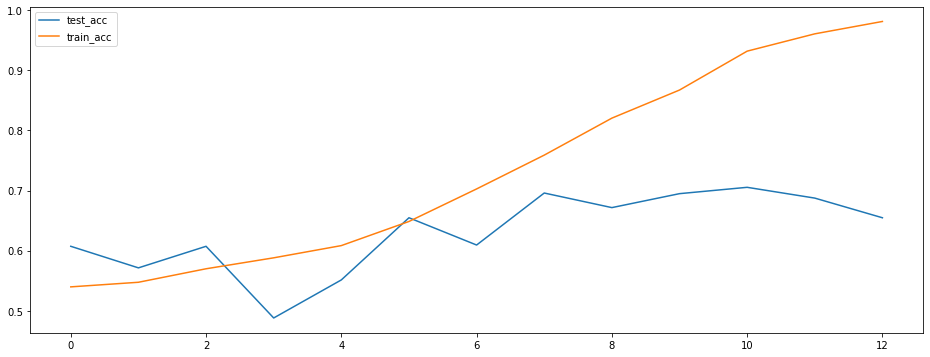

In [140]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_accuracy'], label='test_acc')
plt.plot(history.history['accuracy'], label='train_acc')
plt.legend()

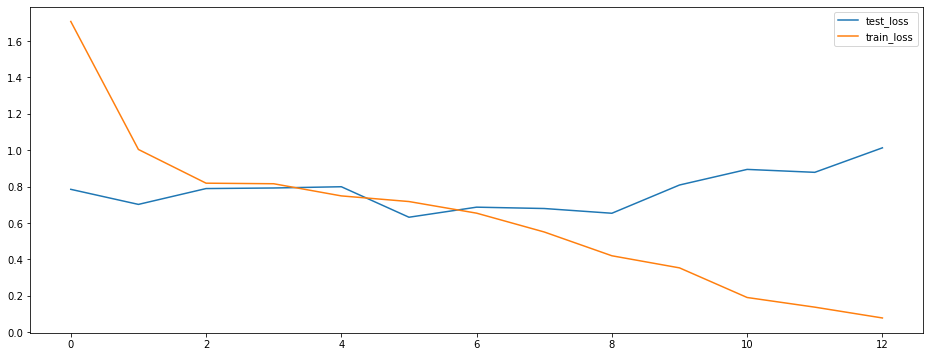

In [141]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_loss'], label='test_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.legend()

In [142]:
test_pred = model.predict([x_test,new_test])
accuracy_score(y_test, test_pred.round())

0.6546990496304118

In [143]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       575
           1       0.55      0.65      0.59       372

    accuracy                           0.65       947
   macro avg       0.65      0.65      0.65       947
weighted avg       0.67      0.65      0.66       947



[[380 195]
 [132 240]]


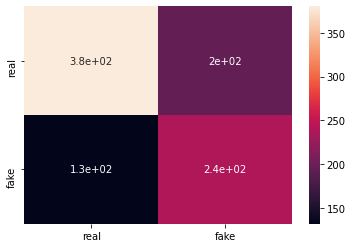

In [144]:
matrix = confusion_matrix(y_test, test_pred.round())
print(matrix)

#Plot
df_cm = pd.DataFrame(matrix, columns=['real','fake'], index=['real', 'fake'])
sns.heatmap(df_cm, annot=True)

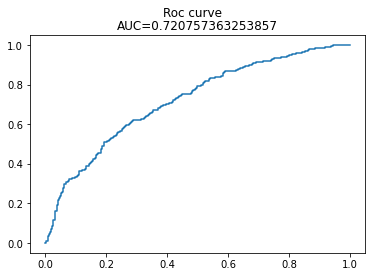

In [145]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
auc = metrics.roc_auc_score(y_test, test_pred)

fig,ax = plt.subplots()
ax.set_title('AUC={}'.format(auc))
fig.suptitle('Roc curve')
ax.plot(fpr,tpr)

In [146]:
test_pred2 = model.predict([padded_test,explicit_test])
test2 = test.copy()
test2["label"] = test_pred2
for i in range(len(test2)):
    if test2.label[i] <0.5:
        test2.label[i] = 0 
    else:
        test2.label[i] = 1

<ipython-input-146-c32d210a8fe8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2.label[i] = 0
<ipython-input-146-c32d210a8fe8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2.label[i] = 1


## CNN-GRU Model

In [147]:
model = Sequential()
model.add(Embedding(vocab_size+1, 100, input_length=500))
model.add(Conv1D(32,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(64,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.35))
model.add(Conv1D(128,kernel_size=3,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))
model.add(GRU(50,return_sequences=True))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 100)          5660900   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 500, 32)           9632      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 250, 32)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 250, 32)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 250, 64)           6208      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 125, 64)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 125, 64)          

In [148]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 100)          5660900   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 500, 32)           9632      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 250, 32)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 250, 32)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 250, 64)           6208      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 125, 64)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 125, 64)          

In [149]:
history = model.fit(x_train, y_train, epochs=20, batch_size=100, validation_data=(x_test, y_test),callbacks = [k.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, min_delta = 0.01)])

Epoch 1/20
38/38 [==============================] - 18s 462ms/step - loss: 0.6736 - accuracy: 0.6041 - val_loss: 0.6658 - val_accuracy: 0.6072
Epoch 2/20
38/38 [==============================] - 16s 432ms/step - loss: 0.6067 - accuracy: 0.6562 - val_loss: 0.5719 - val_accuracy: 0.7012
Epoch 3/20
38/38 [==============================] - 14s 375ms/step - loss: 0.3189 - accuracy: 0.8737 - val_loss: 0.5332 - val_accuracy: 0.7487
Epoch 4/20
38/38 [==============================] - 13s 341ms/step - loss: 0.0975 - accuracy: 0.9701 - val_loss: 0.8266 - val_accuracy: 0.7276
Epoch 5/20
38/38 [==============================] - 13s 336ms/step - loss: 0.0408 - accuracy: 0.9873 - val_loss: 1.0052 - val_accuracy: 0.7307


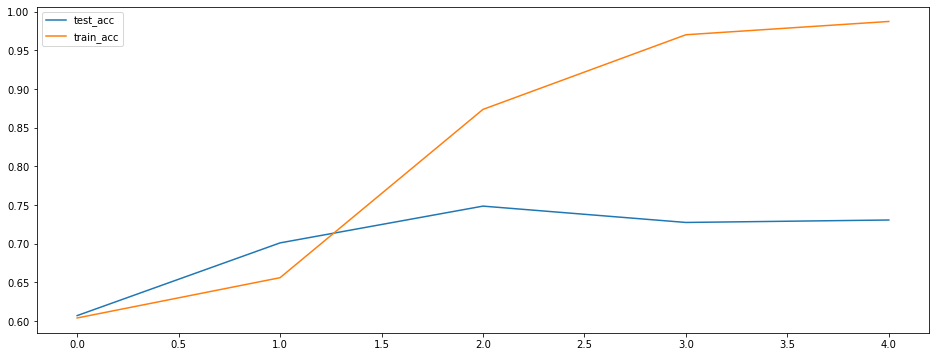

In [150]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_accuracy'], label='test_acc')
plt.plot(history.history['accuracy'], label='train_acc')
plt.legend()

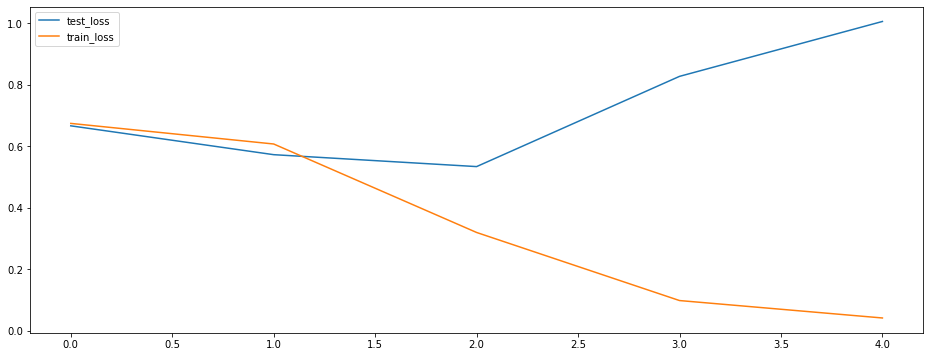

In [151]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_loss'], label='test_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.legend()

In [152]:
test_pred = model.predict(x_test)
accuracy_score(y_test, test_pred.round())

0.7307286166842661

In [153]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       575
           1       0.63      0.76      0.69       372

    accuracy                           0.73       947
   macro avg       0.73      0.74      0.73       947
weighted avg       0.75      0.73      0.73       947



[[408 167]
 [ 88 284]]


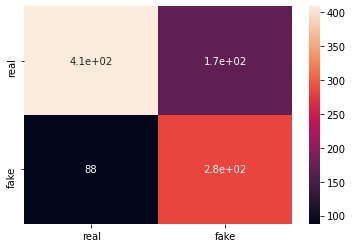

In [154]:
matrix = confusion_matrix(y_test, test_pred.round())
print(matrix)

#Plot
df_cm = pd.DataFrame(matrix, columns=['real','fake'], index=['real', 'fake'])
sns.heatmap(df_cm, annot=True)

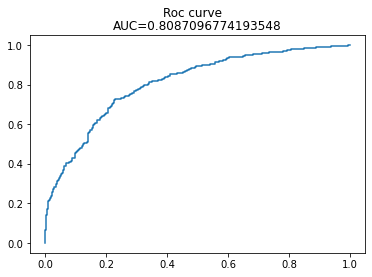

In [155]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
auc = metrics.roc_auc_score(y_test, test_pred)

fig,ax = plt.subplots()
ax.set_title('AUC={}'.format(auc))
fig.suptitle('Roc curve')
ax.plot(fpr,tpr)

In [156]:
test_pred3 = model.predict(padded_test)
test3 = test.copy()
test3["label"] = test_pred3
for i in range(len(test3)):
    if test3.label[i] <0.5:
        test3.label[i] = 0 
    else:
        test3.label[i] = 1

<ipython-input-156-31c01be3e6db>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test3.label[i] = 0
<ipython-input-156-31c01be3e6db>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test3.label[i] = 1


## CNN-GRU Model with textual explicit features

In [157]:
## two shapes of inputs
input_1 = Input(shape=(500,))
input_2 = Input(shape=(8,))

##Text layer
embedding_layer = Embedding(vocab_size+1, 100, weights=[embeddings_matrix])(input_1)
conv1_layer1 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding_layer)
pool_layer1 = MaxPooling1D(pool_size=4)(conv1_layer1)
drop1 = Dropout(0.3)(pool_layer1)

conv1_layer2 = Conv1D(filters=64, kernel_size=3, activation='relu')(drop1)
pool_layer2 = MaxPooling1D(pool_size=4)(conv1_layer2)
drop2 = Dropout(0.35)(pool_layer2)

conv1_layer3 = Conv1D(filters=128, kernel_size=3, activation='relu')(drop2)
pool_layer3 = MaxPooling1D(pool_size=4)(conv1_layer3)
drop3 = Dropout(0.4)(pool_layer3)

GRU1 = GRU(50,return_sequences=True)(drop3)
drop4 = Dropout(0.25)(GRU1)

flat_layer = Flatten()(drop4)

## Textual explicit Features Layer
dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

#Combining layers
concat_layer = Concatenate()([flat_layer, dense_layer_2])
dense_layer_3 = Dense(128, activation='relu')(concat_layer)

dense_layer_4 = Dense(10, activation='relu')(dense_layer_3)

output = Dense(1, activation='sigmoid')(dense_layer_4)
model = Model(inputs=[input_1, input_2], outputs=output)


In [158]:
model.compile(k.optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(k.optimizers.SGD(lr=0.1, momentum = 0.1), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(k.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 500, 100)     5660900     input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 498, 32)      9632        embedding_6[0][0]                
__________________________________________________________________________________________________
max_pooling1d_14 (MaxPooling1D) (None, 124, 32)      0           conv1d_14[0][0]                  
_______________________________________________________________________________________

In [159]:
history = model.fit([x_train,new_train], y_train, epochs=30, batch_size=100, validation_data=([x_test,new_test], y_test),callbacks = [k.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta = 0.01)])

Epoch 1/30
38/38 [==============================] - 10s 255ms/step - loss: 4.9719 - accuracy: 0.5180 - val_loss: 1.6153 - val_accuracy: 0.6082
Epoch 2/30
38/38 [==============================] - 9s 241ms/step - loss: 0.9509 - accuracy: 0.5375 - val_loss: 0.7325 - val_accuracy: 0.6040
Epoch 3/30
38/38 [==============================] - 9s 242ms/step - loss: 0.7619 - accuracy: 0.5806 - val_loss: 0.7262 - val_accuracy: 0.5259
Epoch 4/30
38/38 [==============================] - 9s 240ms/step - loss: 1.1010 - accuracy: 0.5727 - val_loss: 1.1598 - val_accuracy: 0.6072
Epoch 5/30
38/38 [==============================] - 11s 298ms/step - loss: 0.7955 - accuracy: 0.5690 - val_loss: 1.1315 - val_accuracy: 0.6072
Epoch 6/30
38/38 [==============================] - 9s 246ms/step - loss: 0.8196 - accuracy: 0.6284 - val_loss: 0.7053 - val_accuracy: 0.6948
Epoch 7/30
38/38 [==============================] - 9s 241ms/step - loss: 0.6685 - accuracy: 0.7217 - val_loss: 0.6961 - val_accuracy: 0.7402
Epoc

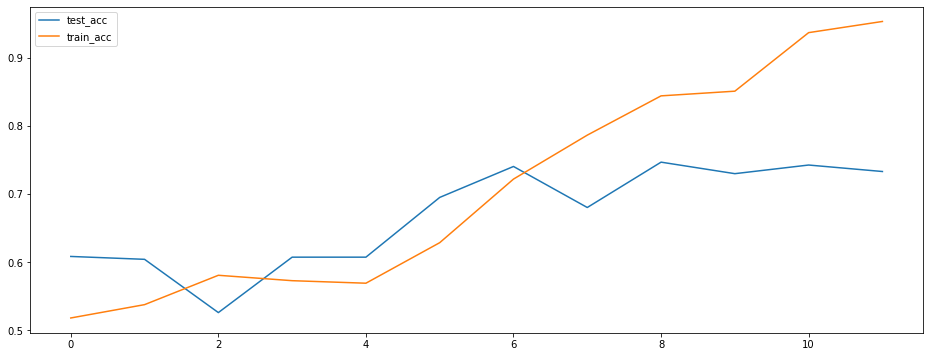

In [160]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_accuracy'], label='test_acc')
plt.plot(history.history['accuracy'], label='train_acc')
plt.legend()

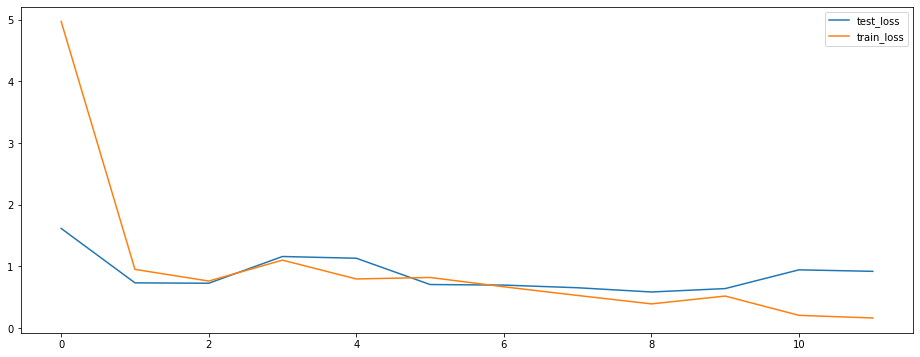

In [161]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_loss'], label='test_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.legend()

In [162]:
test_pred = model.predict([x_test,new_test])
accuracy_score(y_test, test_pred.round())

0.7328405491024287

In [163]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.75      0.83      0.79       575
           1       0.69      0.58      0.63       372

    accuracy                           0.73       947
   macro avg       0.72      0.71      0.71       947
weighted avg       0.73      0.73      0.73       947



[[478  97]
 [156 216]]


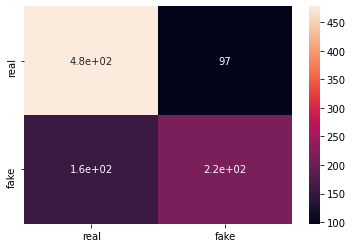

In [164]:
matrix = confusion_matrix(y_test, test_pred.round())
print(matrix)

#Plot
df_cm = pd.DataFrame(matrix, columns=['real','fake'], index=['real', 'fake'])
sns.heatmap(df_cm, annot=True)

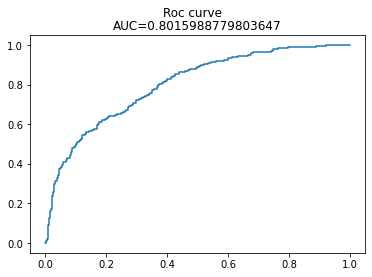

In [167]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
auc = metrics.roc_auc_score(y_test, test_pred)

fig,ax = plt.subplots()
ax.set_title('AUC={}'.format(auc))
fig.suptitle('Roc curve')
ax.plot(fpr,tpr)

In [215]:
test_pred4 = model.predict([padded_test,explicit_test])
test4 = test.copy()
test4["label"] = test_pred4
for i in range(len(test4)):
    if test4.label[i] <0.5:
        test4.label[i] = 0 
    else:
        test4.label[i] = 1

<ipython-input-215-e328455c712a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test4.label[i] = 0
<ipython-input-215-e328455c712a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test4.label[i] = 1


## Saving all the files

In [217]:
submission1= test1[["id","label"]].copy()
submission1["label"] = submission1.label.astype("int")
filename = 'submission1.csv'
submission1.to_csv(filename,index=False)

In [208]:
submission2= test2[["id","label"]].copy()
submission2["label"] = submission2.label.astype("int")
filename = 'submission2.csv'
submission2.to_csv(filename,index=False)

In [209]:
submission3= test3[["id","label"]].copy()
submission3["label"] = submission3.label.astype("int")
filename = 'submission3.csv'
submission3.to_csv(filename,index=False)

In [214]:
submission4= test4[["id","label"]].copy()
submission4["label"] = submission4.label.astype("int")
filename4 = 'submission4.csv'
submission4.to_csv(filename4,index=False)